# Gradient verification for the 1D - non reactive transport (diffusion + advection), porosity inversion using mobile concentration observations.

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
import os
from pathlib import Path
import logging
import copy
import time
from typing import Dict, Generator, Iterable
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import nested_grid_plotter as ngp
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import numpy as np

import pandas as pd
import scipy as sp
import gstools as gs

from scipy._lib._util import check_random_state  # To handle random_state
from pyrtid.utils import (
    NDArrayFloat,
    NDArrayInt,
    gen_random_ensemble,
    node_number_to_indices,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure advection - diffusion case in 1D.

In [14]:
nx = 40  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
# Give non regular dimensions to check if all is correct with mesh dimensions
dx = 7.22  # voxel dimension along the x axis
dy = 6.66  # voxel dimension along the y axis

# Time parameters
duration_in_d = 2  # duration in days
duration_in_s = duration_in_d * 3600 * 24
dt_init = 3600  # timestep in seconds
dt_max = dt_init * 2
dt_min = dt_init / 2

c0 = 0  # general initial cocentration
# Hydro parameters
D0 = 1e-20  # 2.3e-3  # 2e-3  # general initial diffusion coefficient [m2/s]
k0 = 1e-3  # general permeability
# Chemistry parameters
c0 = 0.0  # general initial concentration [molal]
c_inj = 1e-5  # molal

storage_coefficient: float = 1e-3

cst_head_left = 9.3  # m
cst_head_right = -5.5  # m

flow_regime = "transient"

crank_flow = 0.7
crank_diff = 0.9
crank_adv = 0.5

# Values for the x axis ()meters
x_positions_in_meters: NDArrayFloat = np.arange(nx) * dx + dx / 2

- Three observation wells

In [15]:
production_locations = [12, 28]
injection_locations = [4, 20, 36]

- Create an initial "bumped" reference distribution for the permeability, and a flat one for the initial estimation.

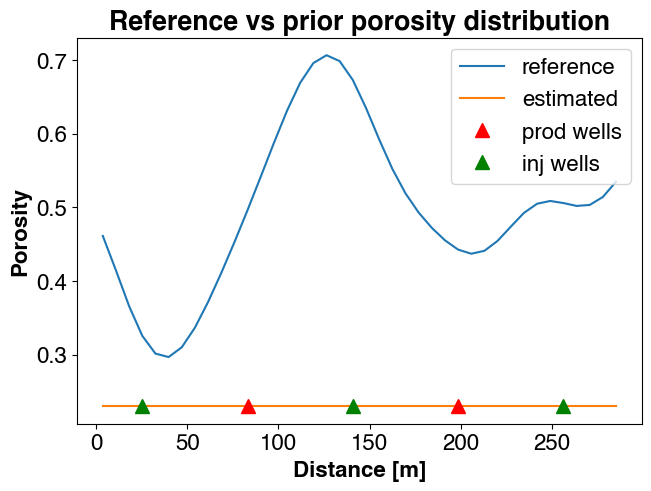

In [16]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 6

min_val = 0.23
max_val = 0.9
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
mean = (max_val + min_val) / 2.0
stdev = (max_val - min_val) / 3.0 / 2.0  # std ~ 1/6 of the distribution interval
len_scale: float = 5.0

poro_reference = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    seed=seed,
)[0, :, :, 0]


# Initial estimate = an homogeneous value + some noise to test the gradient
_random_state = check_random_state(236)
rnd = _random_state.normal(1.0, scale=0.05, size=poro_reference.shape)
poro_estimate = np.ones((nx, ny)) * min_val  # * rnd  # m2/s

plotter = ngp.NestedGridPlotter()
ax = plotter.ax_dict["ax1-1"]

ax.set_xlabel("Distance [m]", fontweight="bold")
ax.set_ylabel("Porosity", fontweight="bold")
ax.set_title("Reference vs prior porosity distribution", fontweight="bold")
plotter.fig.set_facecolor("w")


ax.plot(x_positions_in_meters, poro_reference, label="reference")
ax.plot(x_positions_in_meters, poro_estimate, label="estimated")

# Add some vertical lines to indicate the well
for well_pos in production_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        min_val,
        label="prod wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

for well_pos in injection_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        min_val,
        label="inj wells",
        marker="^",
        markersize=10,
        c="g",
        linestyle="none",
    )

plotter.add_axis_legend("ax1-1")

fname = "ref_vs_prior_porosity"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [17]:
# we also pertubate a bit the diffusion coefficient
diffusion = (
    np.ones((nx, ny))
    * D0
    * _random_state.normal(1.0, scale=0.2, size=poro_reference.shape)
)

diffusion = np.ones((nx, ny)) * D0

- Note: The initial concentration is the same in both cases and has a blocky shape.

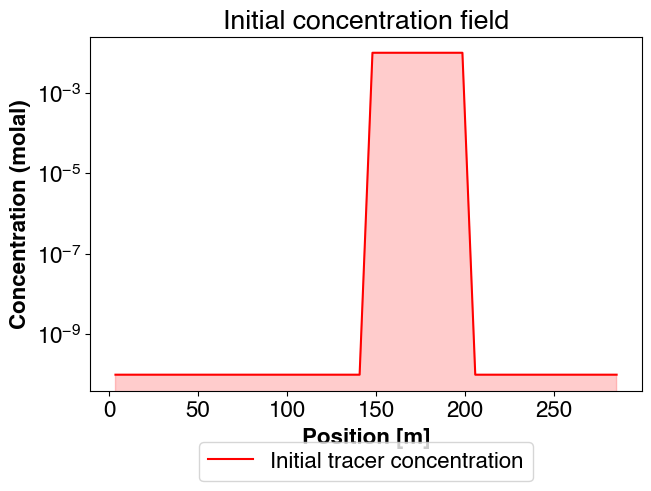

In [18]:
zone_high_conc_start = 20
zone_high_conc_stop = 28

c_min = 1e-10  # [mol/kg]
c_max = 1e-2  # [mol/kg]
c_init = np.ones((nx)) * c_min
c_init[zone_high_conc_start:zone_high_conc_stop] = c_max

plotter = ngp.NestedGridPlotter()
plotter.ax_dict["ax1-1"].plot(
    np.arange(nx) * dx + dx / 2,
    c_init,
    label="Initial tracer concentration",
    color="red",
)
plotter.ax_dict["ax1-1"].fill_between(
    np.arange(nx) * dx + dx / 2,
    0.0,
    c_init,
    alpha=0.2,
    color="red",
)
plotter.ax_dict["ax1-1"].set_xlabel("Position [m]", weight="bold")
plotter.ax_dict["ax1-1"].set_ylabel("Concentration (molal)", weight="bold")
plotter.ax_dict["ax1-1"].set_yscale("log")
plotter.ax_dict["ax1-1"].legend(loc="center", bbox_to_anchor=(0.5, -0.2), ncol=2)
plotter.ax_dict["ax1-1"].set_title("Initial concentration field")
plotter.fig.set_facecolor("w")

fname = "initial_tracer_concentration"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Create the flowrates for the wells: 12 m3/h decreasing following an exponential... for the producers with a balanced injection (2 m3/h per associated cell for the injectors).

In [19]:
def gen_flowrates(amplitude: float, coef: float, nt: int, dt: float) -> NDArrayFloat:
    """Generate flowrates with a given amplitude and decrease coefficient.

    Parameters
    ----------
    amplitude : float
        Amplitude in m3/h.
    coef : float
        Decrease coefficient.
    nt : int
        Number of timesteps
    dt : float
        Timesteps.

    Returns
    -------
    np.ndarray
        The flowrates.
    """
    return amplitude * np.exp(coef * np.arange(nt) * dt)

- Generate a flowrates with an initial amplitude at 1 m3/h and plot it

Text(0.5, 0, 'time [d]')

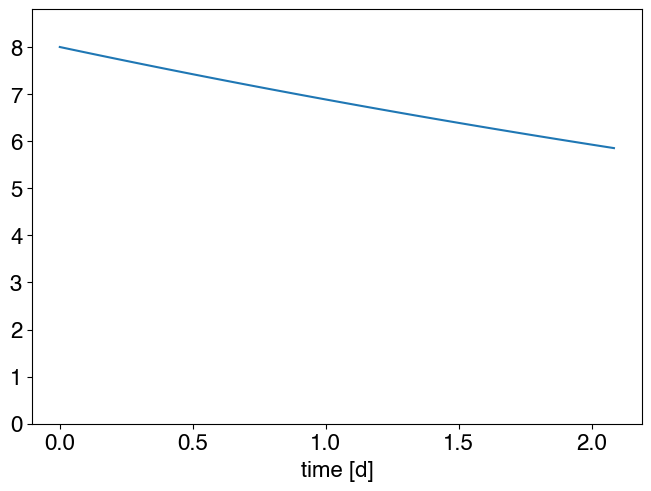

In [20]:
init_prod_flowrates = 8.0  # m3/s
# nt+1 because we consider the initial state too
flowrates = init_prod_flowrates * gen_flowrates(
    1.0, -0.15, nt + 1, dt=dt / 3600 / 24
)  # m3/s

plt.plot(np.arange(nt + 1) * dt / 3600 / 24, flowrates)
plt.ylim(0.0, init_prod_flowrates * 1.1)
plt.xlabel("time [d]")

### Forward problem in demonstrator

- For c_init, need to apply nx+1 in the case of the finite differences for the parameters because of the spatial discretization scheme (finite differences and finite volumes respectively).

In [21]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy)
fl_params = dmfwd.FlowParameters(
    permeability=k0,
    storage_coefficient=storage_coefficient,
    crank_nicolson=crank_flow,
    regime={
        "stationary": dmfwd.FlowRegime.STATIONARY,
        "transient": dmfwd.FlowRegime.TRANSIENT,
    }[flow_regime],
)
tr_params = dmfwd.TransportParameters(
    diffusion=D0,
    porosity=min_val,
    crank_nicolson_diffusion=crank_diff,
    crank_nicolson_advection=crank_adv,
)
gch_params = dmfwd.GeochemicalParameters(conc=c0)
base_model = dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Add boundary conditions

In [22]:
# Boundary conditions
base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(0, 1), slice(None))))
base_model.fl_model.head[0, :, :] = cst_head_left
base_model.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
)
base_model.fl_model.head[-1, :, :] = cst_head_right

- Add source and sink terms

In [23]:
prod_flw = -flowrates / 3600  # m3/h to m3/s
times = np.arange(stop=nt + 1, start=0) * dt

# two successive pumping on days 1 and 2
for loc in production_locations:
    sink_term = dmfwd.SourceTerm(
        f"producer loc # {loc}",
        node_ids=np.array([loc]),
        # pumping on 1 day
        times=times,
        flowrates=prod_flw,
        concentrations=np.zeros(times.shape),
    )
    base_model.add_src_term(sink_term)

n_prod_linked_list = [1, 2, 1]

# three successive injections on days 3, 4 and 5
for count_inj, loc in enumerate(injection_locations):
    source_term = dmfwd.SourceTerm(
        "injector loc # {loc}",
        node_ids=np.array([loc]),
        times=times,
        flowrates=-n_prod_linked_list[count_inj] * prod_flw / 2,
        concentrations=np.ones(times.shape) * c_inj,  # injection concentration
    )
    base_model.add_src_term(source_term)

- Create two models

In [24]:
model_reference = copy.deepcopy(base_model)
model_estimate = copy.deepcopy(base_model)
# Reference
model_reference.tr_model.porosity = poro_reference.reshape(nx, ny)
model_reference.tr_model.diffusion = diffusion.reshape(nx, ny)
# Estimated diffusion
model_estimate.tr_model.porosity = poro_estimate.reshape(nx, ny)
model_estimate.tr_model.diffusion = diffusion.reshape(nx, ny)

# Same concentration in both models
model_reference.tr_model.set_initial_conc(c_init.reshape(nx, ny))
model_estimate.tr_model.set_initial_conc(c_init.reshape(nx, ny))

- Run the models

In [25]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve()

In [26]:
solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

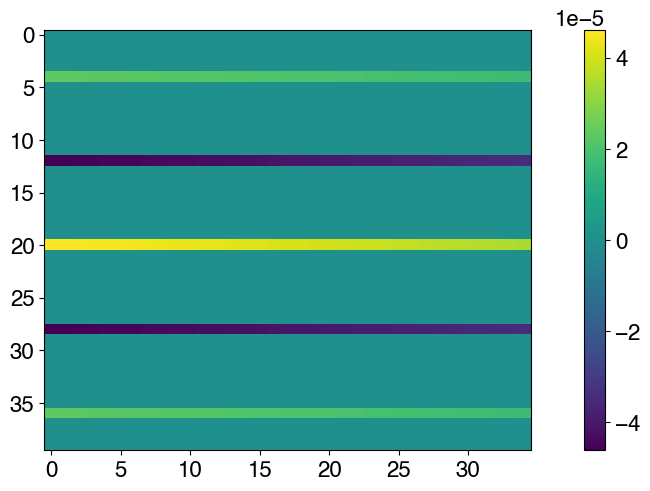

In [28]:
plt.imshow(model_reference.fl_model.unitflow[:, 0, :], aspect="auto")
plt.colorbar()

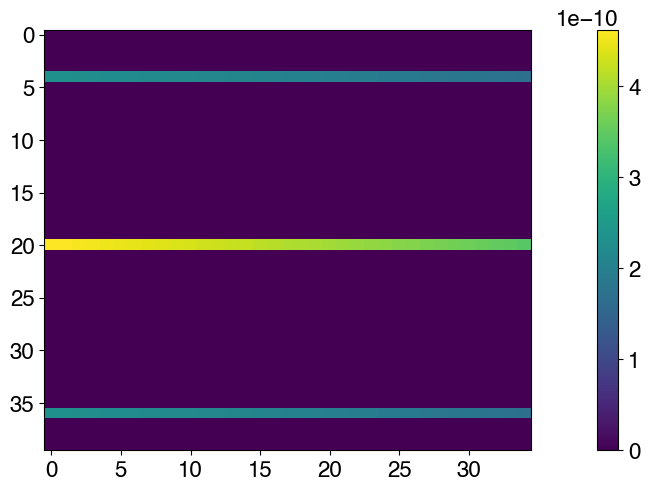

In [29]:
plt.imshow(model_reference.tr_model.sources[0, :, 0, :], aspect="auto")
plt.colorbar()

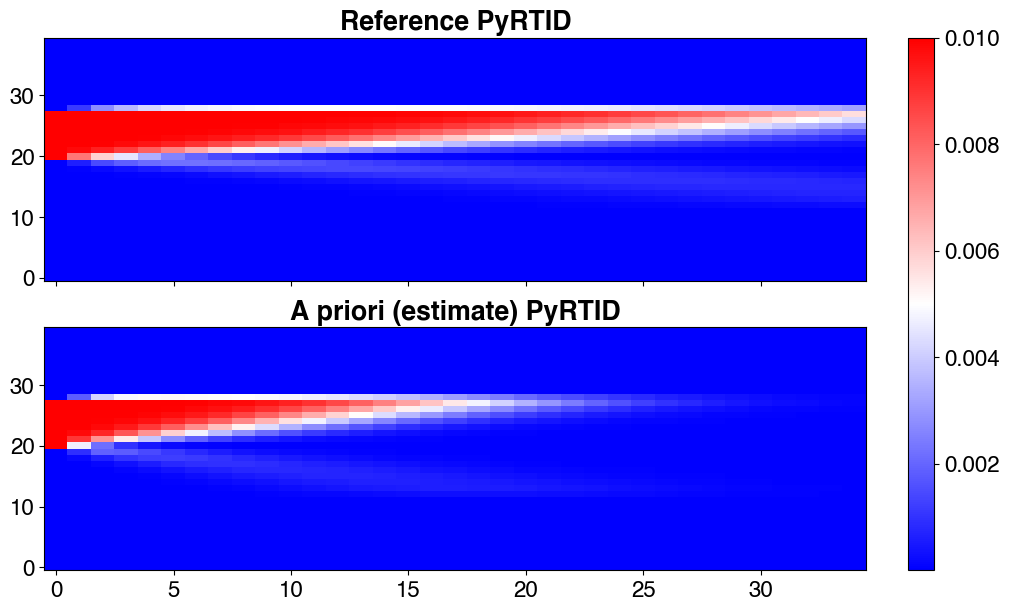

In [30]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 6)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference PyRTID": model_reference.tr_model.conc[:, 0, :].T,
        "A priori (estimate) PyRTID": model_estimate.tr_model.conc[:, 0, :].T,
    },
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### Heads and darcy velocities

- spatial evolution of heads

In [32]:
# function for time display
# plot the time
def get_time(nb_frames: int) -> Generator[str, None, None]:
    ts_btw_frames = model_reference.time_params.nt / nb_frames
    for frame in range(nb_frames):
        yield f"time = {model_reference.time_params.times[int(ts_btw_frames * frame)] / 3600:.3f} h"

In [33]:
model_reference.fl_model.head.shape

(40, 1, 35)

In [34]:
model_estimate.fl_model.head.shape

(40, 1, 35)

In [35]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (7, 5)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

# Animated plot
nb_frames = min(12, model_reference.time_params.nt)


plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "Reference (PyRTID)": {
            "x": x_positions_in_meters,
            "y": model_reference.fl_model.head[:, 0, :],
            "kwargs": {"c": "green"},
        },
        "Estimated (PyRTID)": {
            "x": x_positions_in_meters,
            "y": model_estimate.fl_model.head[:, 0, :],
            "kwargs": {"c": "orange", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="PyRTID head",
    xlabel="X [m]",
)


for ax_name in ["ax1-1"]:
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx
            - dx / 2,  # Well pos + 1 because of indexing that starts at zero
            c_min,
            label="prod wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    for well_pos in injection_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx - dx / 2,
            0.0,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time(nb_frames)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name, loc="lower left")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- spatial and temporal evolution of darcy velocities

In [36]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

# Animated plot
nb_frames = min(12, model_reference.time_params.nt)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "Reference": {
            "x": x_positions_in_meters,
            "y": model_reference.fl_model.u_darcy_x_center[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "x": x_positions_in_meters,
            "y": model_estimate.fl_model.u_darcy_x_center[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="PyRTID flowrates",
    xlabel="X [m]",
)

for ax_name in ["ax1-1"]:
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx
            - dx / 2,  # Well pos + 1 because of indexing that starts at zero
            c_min,
            label="prod wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    for well_pos in injection_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx - dx / 2,
            0.0,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time(nb_frames)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name, loc="lower left")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


### Tracer concentrations

- Forward variables at the producer locations

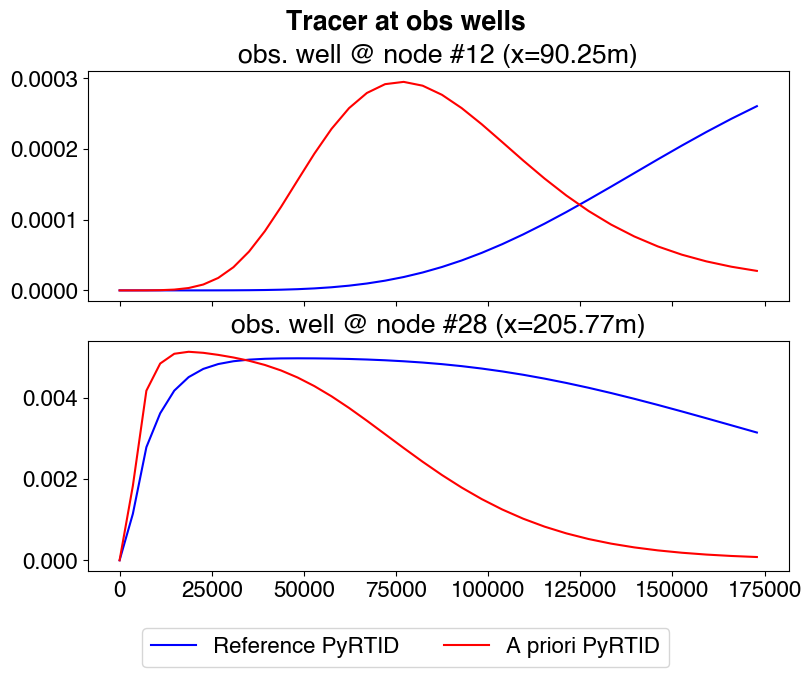

In [37]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(production_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x:.2f}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.time_params.times,
        model_reference.tr_model.conc[node_id, 0, :],
        label="Reference PyRTID",
        c="b",
    )
    ax.plot(
        model_estimate.time_params.times,
        model_estimate.tr_model.conc[node_id, 0, :],
        label="A priori PyRTID",
        c="r",
    )

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [38]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

# Animated plot
nb_frames = min(12, model_reference.time_params.nt)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "True": {
            "x": x_positions_in_meters,
            "y": model_reference.tr_model.conc[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "x": x_positions_in_meters,
            "y": model_estimate.tr_model.conc[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Demonstrator conc",
    xlabel="X [m]",
)


for ax_name in ["ax1-1"]:
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx
            - dx / 2,  # Well pos + 1 because of indexing that starts at zero
            c_min,
            label="prod wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    for well_pos in injection_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx - dx / 2,
            c_min,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time(nb_frames)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Inversion

- Create a function to add some noise to the observations

In [39]:
freq_measure_in_d = 0.25  # one measure every two days
n_sampled_days = duration_in_d / freq_measure_in_d

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_d
obs_times_in_s

array([     0.,  21600.,  43200.,  64800.,  86400., 108000., 129600.,
       151200.])

In [43]:
noise_std: float = 5e-6  # This is an absolute value


def get_white_noise(shape: Iterable[int]) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise(
    (len(production_locations), obs_times_in_s.size)
)

- Check the intensity of the noise

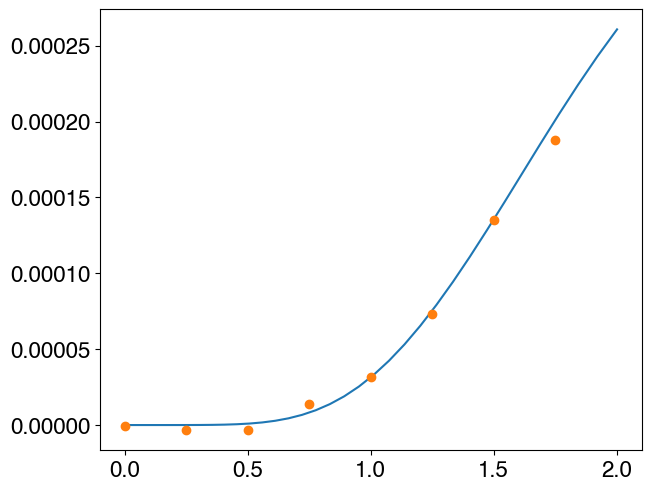

In [44]:
all_times = model_estimate.time_params.times

obs_values = np.zeros((len(production_locations), obs_times_in_s.size))

for count, ix in enumerate(production_locations):
    # interpolate the values
    obs_values[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.tr_model.conc[ix, 0, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise[count, :]
    )

count = 0

ix = production_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.tr_model.conc[ix, 0, :])
plt.plot(
    obs_times_in_s / 3600 / 24,
    obs_values[count],
    marker="o",
    linestyle="none",
)

# Inversion

## Observation noise generation
- Create a function to add some noise to the observations

In [45]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.POROSITY,
    lbounds=0.05,
    ubounds=1.0,
    preconditioner=dminv.LogTransform(),
)

observables = []
for i, node_id in enumerate(production_locations):
    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.CONCENTRATION,
            node_indices=node_id,
            times=obs_times_in_s,
            values=obs_values[i],
            uncertainties=noise_std,
            sp=0,
        )
    )

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=True,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)


executor.eval_scaled_loss(param.preconditioner(param.values))

is_grad_ok = executor.is_adjoint_gradient_correct()

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 59866.453049783675
INFO:root:Loss (regularization) = 0.0
INFO:root:Regularization weight = 0.0
INFO:root:Scaling factor        = 1.6703845794378717e-05
INFO:root:Loss (scaled)         = 1.0



ValueError: operands could not be broadcast together with shapes (40,1,35) (40,1,34) (40,1,35) 

In [ ]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


- Plot the first gradient

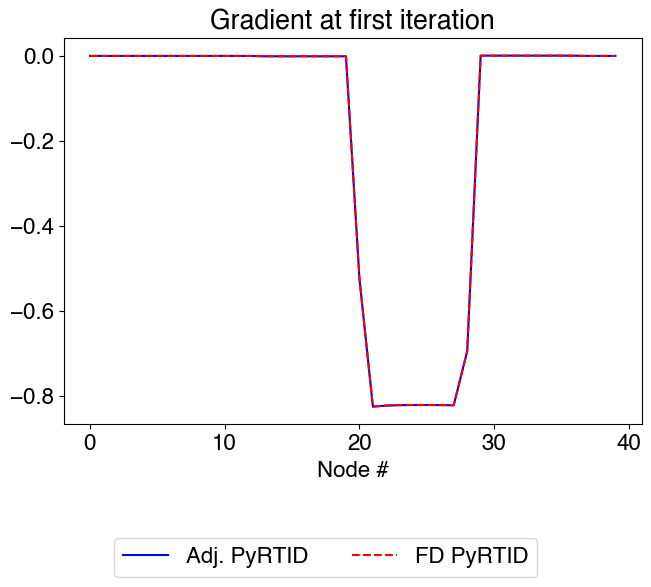

In [ ]:
scaling_factor = executor.inv_model.scaling_factor

# Here comes the python code
plotter = ngp.NestedGridPlotter()

ax = plotter.get_axis("ax1-1")
ax.plot(param.grad_adj_history[0] * scaling_factor, label="Adj. PyRTID", c="b")
# ax.plot(my_gradient[:, 0] * scaling_factor, label="Adj. PyRTID", c="b")
ax.plot(
    param.grad_fd_history[0] * scaling_factor,
    label="FD PyRTID",
    c="r",
    linestyle="--",
)
# ax.plot(-executor.fwd_model.fl_model.u_darcy_x[:, 0, 0] * 500)

ax.set_title("Gradient at first iteration")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_pyrtid_adj_vs_df_1d_permeability"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

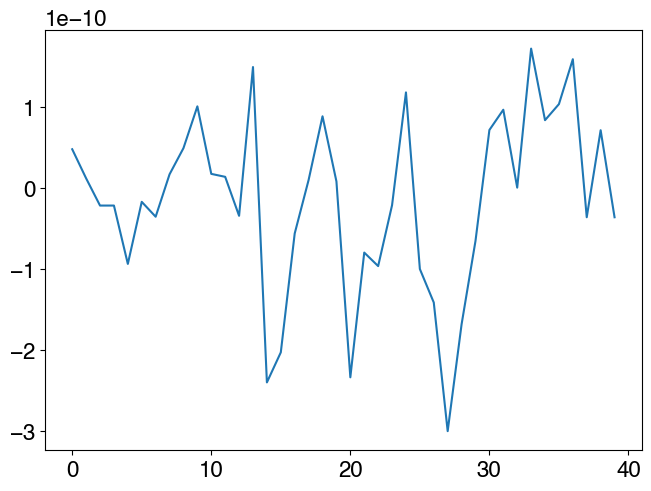

In [ ]:
plt.plot(
    (param.grad_fd_history[0][:, 0] - param.grad_adj_history[0][:, 0]) * scaling_factor
)

## HYTEC

In [ ]:
# 1) Copy the base simulation
simu_inverse = copy.deepcopy(simu_estimate)
simu_inverse.update_root_and_name(new_root="simu_inverse", new_name="simu_inverse")

# 2) Add the observation wells
for count, ix in enumerate(production_locations):
    x = (ix + 0.5) * geometry.dx
    zone_name = f"producer_{ix}"
    # zone = simu_inverse.model.get_sub_model(hymd.GeometryModel).get_zone(name)

    vals = fwd_conc_reference_hytec[ix, 0, 0, :] + obs_noise[count]

    # Add the observables for the area
    obs = Observable(
        zone_name=zone.name,
        state_variable=species,
        units="mol/kg",
        timesteps=grid_sample_times,
        time_units="s",
        obs_type=ObservationType.GRID,
        values=vals,
        uncertainties=np.ones(vals.size) * noise_std,
        node_numbers=np.ones(vals.size) * ix,
    )
    simu_inverse.register_observable(
        zone_name, obs, obs_file_path=f"observables/{zone_name}_{species}_o.dat"
    )

# 3) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb",
        hymd.AdjointStateStatus("enabled"),
        hymd.FdGradientCheck("initial"),
    ),
    hymd.AdjustedParameterConfig(
        "porosity",
        hymd.Lbound(0.05, units=""),
        hymd.Ubound(1.0, units=""),
    ),
)
simu_inverse.model.add_sub_item(inv_model)

# number of samples on the adjoint variables
simu_inverse.model.get_sub_model(hymd.SamplingModel).add_sub_item(
    hymd.AdjointGridSampling(nt)
)

# 4)Write the input files
simu_inverse.write_input_files()

runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written

INFO:root:The job is over ! Elapsed time = 0:00:23.291695


- Extract the adjoint variables computed for the first gradient

In [ ]:
print(f"columns = {simu_inverse.handlers.results.optim_res.adjoint_var_columns}")

columns = ['timestep', 'Zones', 'node-number []', 'adjoint-variable{head} []', 'adjoint-variable{T} []', 'x-distance']


In [ ]:
adj_conc_hytec = simu_inverse.handlers.results.extract_field_from_adj_var_res(
    field="adjoint-variable{T} []", nx=nx
)
adj_conc_hytec.shape

(40, 1, 1, 51)

### Results comparison

The adjoint concentrations should be quite the same both in shape and intensity.

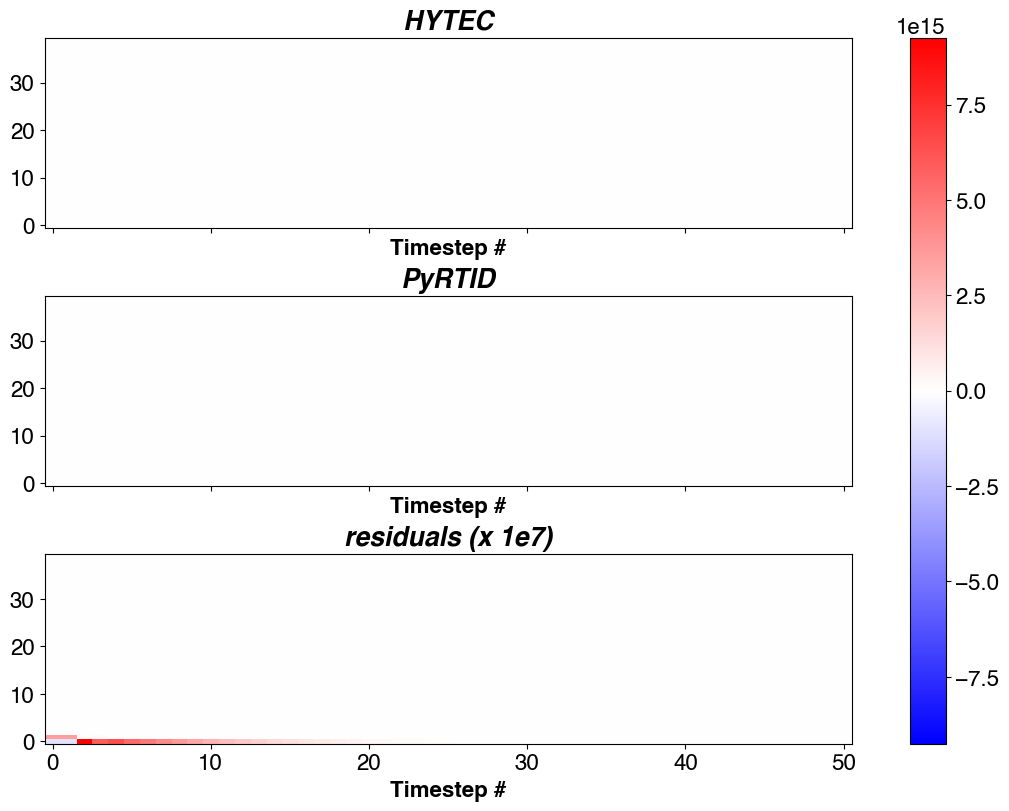

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 8)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "HYTEC": executor.adj_model.a_tr_model.a_conc[:, 0, :].T,
        "PyRTID": adj_conc_hytec[:, 0, 0, :].T,
        "residuals (x 1e7)": (
            adj_conc_hytec[:, 0, 0, :].T
            - executor.adj_model.a_tr_model.a_conc[:, 0, :].T
        )
        * 1e7,
    },
    is_symmetric_cbar=True,
    xlabel="Timestep #",
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

Let's check the adjoint variables at the three observation wells. Note that only the right one has been used as an adjoint source (node_id == 15).

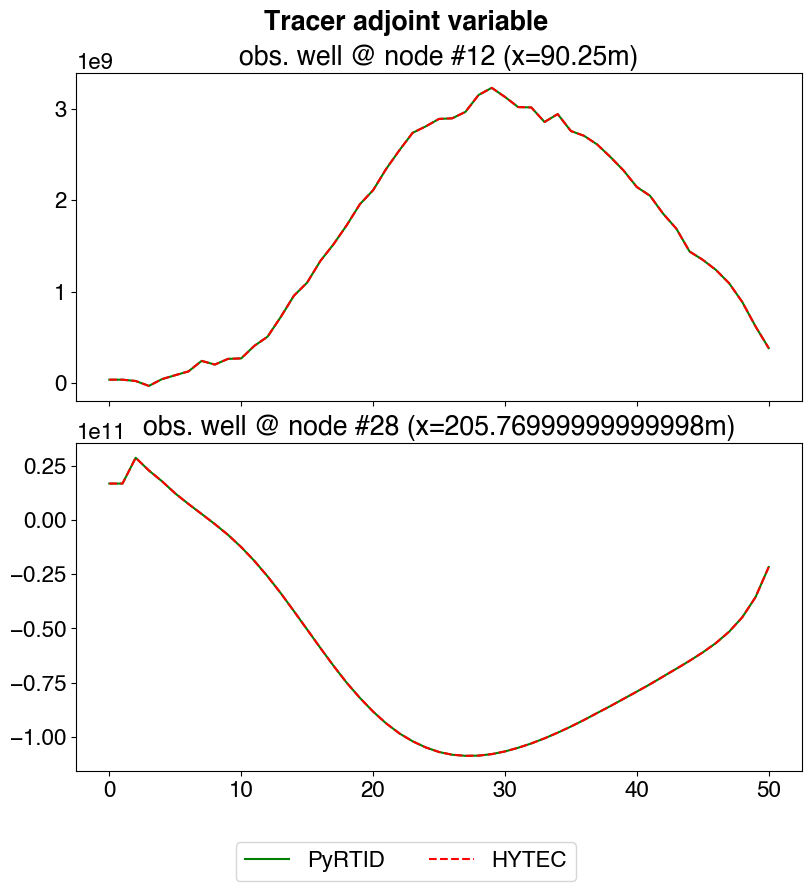

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"]], sharey=False, sharex=True)
    },
)

for i, node_id in enumerate(production_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(executor.adj_model.a_tr_model.a_conc[node_id, 0, :], label="PyRTID", c="g")
    ax.plot(adj_conc_hytec[node_id, 0, 0, :], label="HYTEC", c="r", linestyle="--")

plotter.fig.suptitle("Tracer adjoint variable", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "adjoint_concentrations_dem_vs_hytec_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Get the gradients by the adjoint method and finite differences

Finally, plot the gradients comparison.

In [ ]:
# Get the HYTEC  Adj gradient
hytec_fd_gradient = simu_inverse.handlers.results.optim_res.fd_gradients[0]
hytec_adjoint_gradient = simu_inverse.handlers.results.optim_res.adjoint_gradients[0]

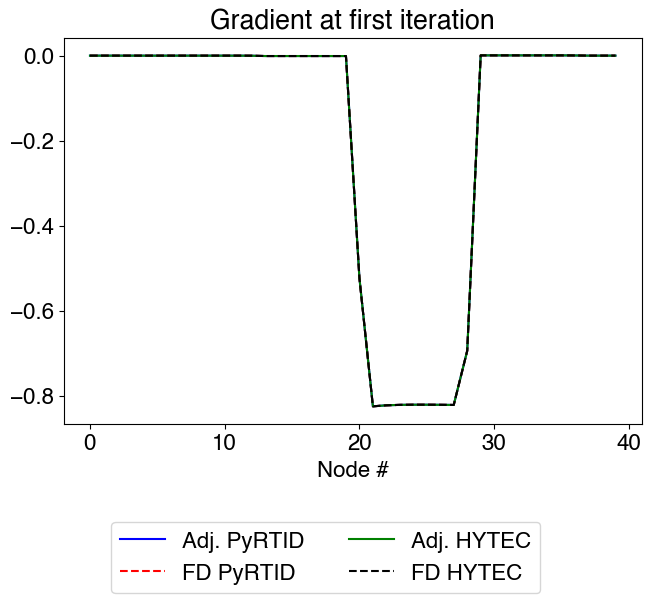

In [ ]:
scaling_factor = executor.inv_model.scaling_factor

# Here comes the python code
plotter = ngp.NestedGridPlotter()

ax = plotter.get_axis("ax1-1")
ax.plot(param.grad_adj_history[0] * scaling_factor, label="Adj. PyRTID", c="b")
ax.plot(
    param.grad_fd_history[0] * scaling_factor,
    label="FD PyRTID",
    c="r",
    linestyle="--",
)
ax.plot(hytec_adjoint_gradient["value"], label="Adj. HYTEC", c="g")
ax.plot(hytec_fd_gradient["value"], label="FD HYTEC", c="k", linestyle="--")

ax.set_title("Gradient at first iteration")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_permeability"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

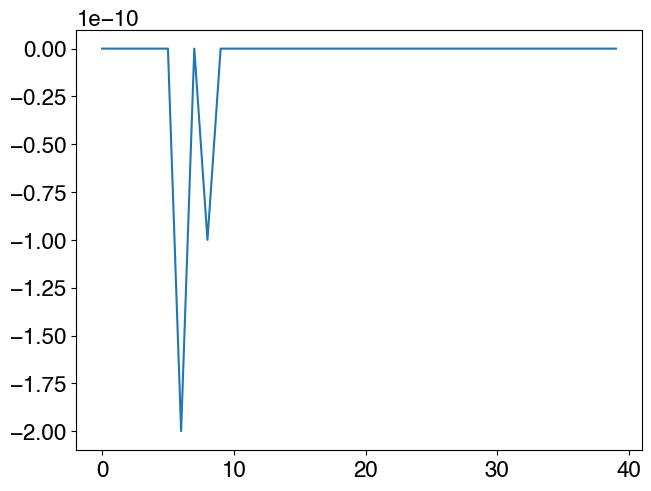

In [ ]:
plt.plot(hytec_adjoint_gradient["value"] - hytec_fd_gradient["value"])